## Importation des bibliothèques

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

2024-03-18 14:50:08.022786: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 14:50:08.076154: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 14:50:08.288506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 14:50:09.223647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
data_dir = 'data/photos_raw/'

### CNN

## Chargement du modèle

In [4]:
# Importation du modèle EfficientNetV2M pré-entraîné sur ImageNet
base_model = EfficientNetV2M(include_top=False, weights='imagenet', input_shape=(480, 480, 3))

# Désactivation de l'entraînement pour toutes les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Création d'une couche d'aplatissement pour convertir les données en un vecteur unidimensionnel
flat1 = Flatten()(base_model.output)

# Ajout d'une couche dense avec 1024 neurones et une fonction d'activation ReLU
class1 = Dense(1024, activation='relu')(flat1)

# Couche de sortie avec une activation softmax pour la classification multi-classes (food, drink, other)
output = Dense(3, activation='softmax')(class1)

# Création du modèle en spécifiant les entrées et les sorties
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle avec l'optimiseur Adam, la perte de catégorisation croisée et la métrique de précision
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-03-18 14:50:09.916511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 14:50:09.917085: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-03-18 14:50:13.646384: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1179648000 exceeds 10% of free system memory.
2024-03-18 14:50:14.081233: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1179648000 exceeds 

## Preparation des données

In [5]:
# Création d'un générateur de données pour l'entraînement avec une validation de 20%
train_datagen = ImageDataGenerator(validation_split=0.2)

# Création d'un générateur de lot pour les données d'entraînement à partir du répertoire spécifié
train_generator = train_datagen.flow_from_directory(
    data_dir,  # Répertoire contenant les données
    target_size=(480, 480),  # Redimensionnement des images à la taille spécifiée
    batch_size=32,  # Taille du lot
    class_mode='categorical',  # Mode de classification (dans ce cas, catégorique pour plusieurs classes)
    subset='training',  # Utilisation du sous-ensemble d'entraînement
    shuffle=True  # Mélange aléatoire des données à chaque époque
)

# Création d'un générateur de lot pour les données de validation à partir du même répertoire
validation_generator = train_datagen.flow_from_directory(
    data_dir,  # Répertoire contenant les données
    target_size=(480, 480),  # Redimensionnement des images à la taille spécifiée
    batch_size=32,  # Taille du lot
    class_mode='categorical',  # Mode de classification (catégorique pour plusieurs classes)
    subset='validation',  # Utilisation du sous-ensemble de validation
    shuffle=True  # Mélange aléatoire des données à chaque époque
)

Found 480 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


## Entraînement du modèle

In [6]:
# Importation de la fonctionnalité d'arrêt anticipé pour arrêter l'entraînement lorsque la perte de validation cesse de s'améliorer
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveillance de la perte de validation
    patience=3,  # Nombre d'époques sans amélioration avant d'arrêter l'entraînement
    verbose=1,  # Niveau de verbosité (1 pour afficher des messages)
    mode='min',  # Mode de comparaison ('min' pour minimiser la perte de validation)
    restore_best_weights=True  # Restauration des poids du modèle aux meilleurs poids enregistrés
)

In [7]:
# Nombre d'époques pour l'entraînement du modèle
nb_epoch = 20

# Entraînement du modèle avec les générateurs de données d'entraînement et de validation
# et utilisation de la fonction d'arrêt anticipé pour éviter le surapprentissage
history = model.fit(
    train_generator,  # Générateur de données d'entraînement
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Nombre d'étapes par époque
    validation_data=validation_generator,  # Générateur de données de validation
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Nombre d'étapes de validation par époque
    epochs=nb_epoch,  # Nombre total d'époques pour l'entraînement
    callbacks=[early_stopping]  # Liste des rappels, dans ce cas, l'arrêt anticipé
)

Epoch 1/20


2024-03-18 14:50:24.333985: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1179648000 exceeds 10% of free system memory.
/home/becker/Projets/Kookeat-ia/mon_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-18 14:50:58.247391: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1179648000 exceeds 10% of free system memory.


15/15 ━━━━━━━━━━━━━━━━━━━━ 425s 27s/step - accuracy: 0.5820 - loss: 42.7034 - val_accuracy: 0.9479 - val_loss: 4.3661
Epoch 2/20


2024-03-18 14:57:20.214358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-18 14:57:34.119129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 971ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 1.0858
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 395s 27s/step - accuracy: 0.9380 - loss: 3.6713 - val_accuracy: 0.9271 - val_loss: 4.2989
Epoch 4/20


2024-03-18 15:04:09.993438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-18 15:04:23.837243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 953ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.8829
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 396s 27s/step - accuracy: 0.9864 - loss: 0.2113 - val_accuracy: 0.9271 - val_loss: 1.8766
Epoch 6/20


2024-03-18 15:10:59.888579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-18 15:11:14.206645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 980ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.1549
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 394s 26s/step - accuracy: 0.9900 - loss: 1.3310 - val_accuracy: 0.9271 - val_loss: 2.0379
Epoch 8/20


2024-03-18 15:17:49.066659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-18 15:18:02.815758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 943ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 395s 26s/step - accuracy: 0.9870 - loss: 0.2091 - val_accuracy: 0.9375 - val_loss: 1.8671
Epoch 10/20


2024-03-18 15:24:38.236419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-18 15:24:52.068426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 951ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.7385e-08
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 383s 26s/step - accuracy: 0.9934 - loss: 0.1490 - val_accuracy: 0.9479 - val_loss: 1.4699
Epoch 12/20


2024-03-18 15:31:15.519079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 761ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.0477
Epoch 13/20


2024-03-18 15:31:26.881626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 320s 21s/step - accuracy: 1.0000 - loss: 2.4041e-05 - val_accuracy: 0.9583 - val_loss: 0.8893
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.


## Performance

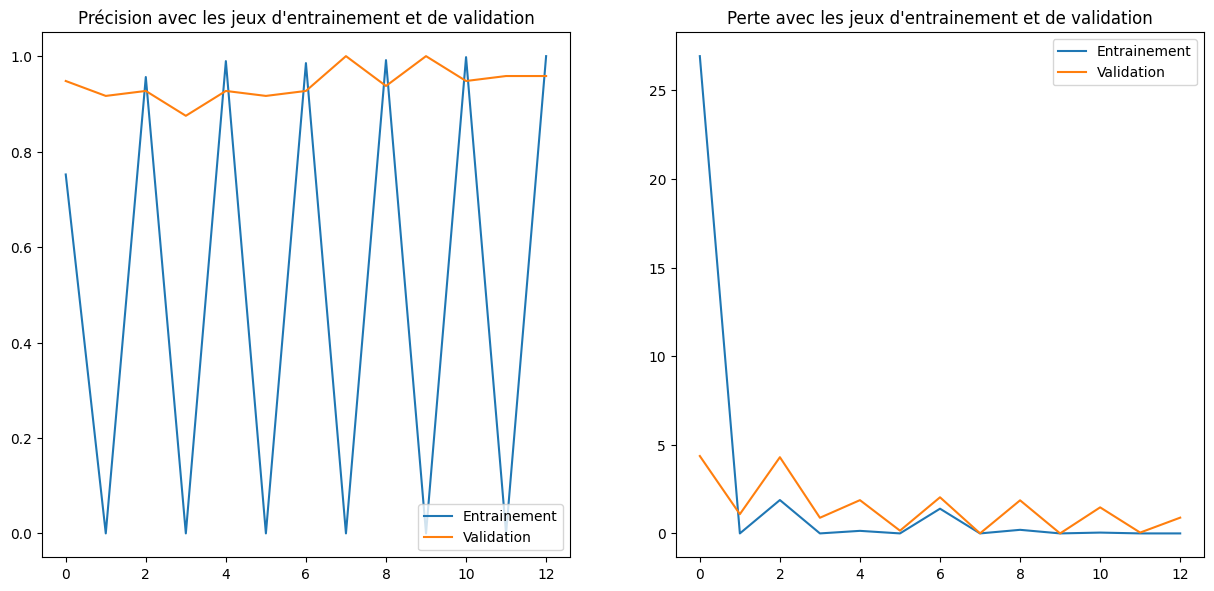

In [8]:
# Extraction des données d'entraînement et de validation de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Nombre d'époques
epochs_range = range(len(acc))

# Tracé des graphiques de précision et de perte pour les jeux d'entraînement et de validation
plt.figure(figsize=(12, 8))

# Graphique de précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Entrainement")  # Précision d'entraînement
plt.plot(epochs_range, val_acc, label='Validation')  # Précision de validation
plt.legend(loc='lower right')
plt.title("Précision avec les jeux d'entrainement et de validation")
plt.xlabel('Nombre d\'époques')
plt.ylabel('Précision')

# Ajout des annotations pour les valeurs de précision à chaque époque
for i, acc_value in enumerate(acc):
    plt.text(i, acc_value, f'{acc_value:.2f}', ha='center', va='bottom')

for i, val_acc_value in enumerate(val_acc):
    plt.text(i, val_acc_value, f'{val_acc_value:.2f}', ha='center', va='bottom')

# Graphique de perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrainement')  # Perte d'entraînement
plt.plot(epochs_range, val_loss, label='Validation')  # Perte de validation
plt.legend(loc='upper right')
plt.title("Perte avec les jeux d'entrainement et de validation")
plt.xlabel('Nombre d\'époques')
plt.ylabel('Perte')

# Ajout des annotations pour les valeurs de perte à chaque époque
for i, loss_value in enumerate(loss):
    plt.text(i, loss_value, f'{loss_value:.2f}', ha='center', va='bottom')

for i, val_loss_value in enumerate(val_loss):
    plt.text(i, val_loss_value, f'{val_loss_value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Save

In [9]:
# Sauvegarde du modèle entraîné au format h5
model.save("model.h5")

# Chargement du modèle à partir du fichier h5 sauvegardé
loaded_model = load_model("model.h5")

# Test

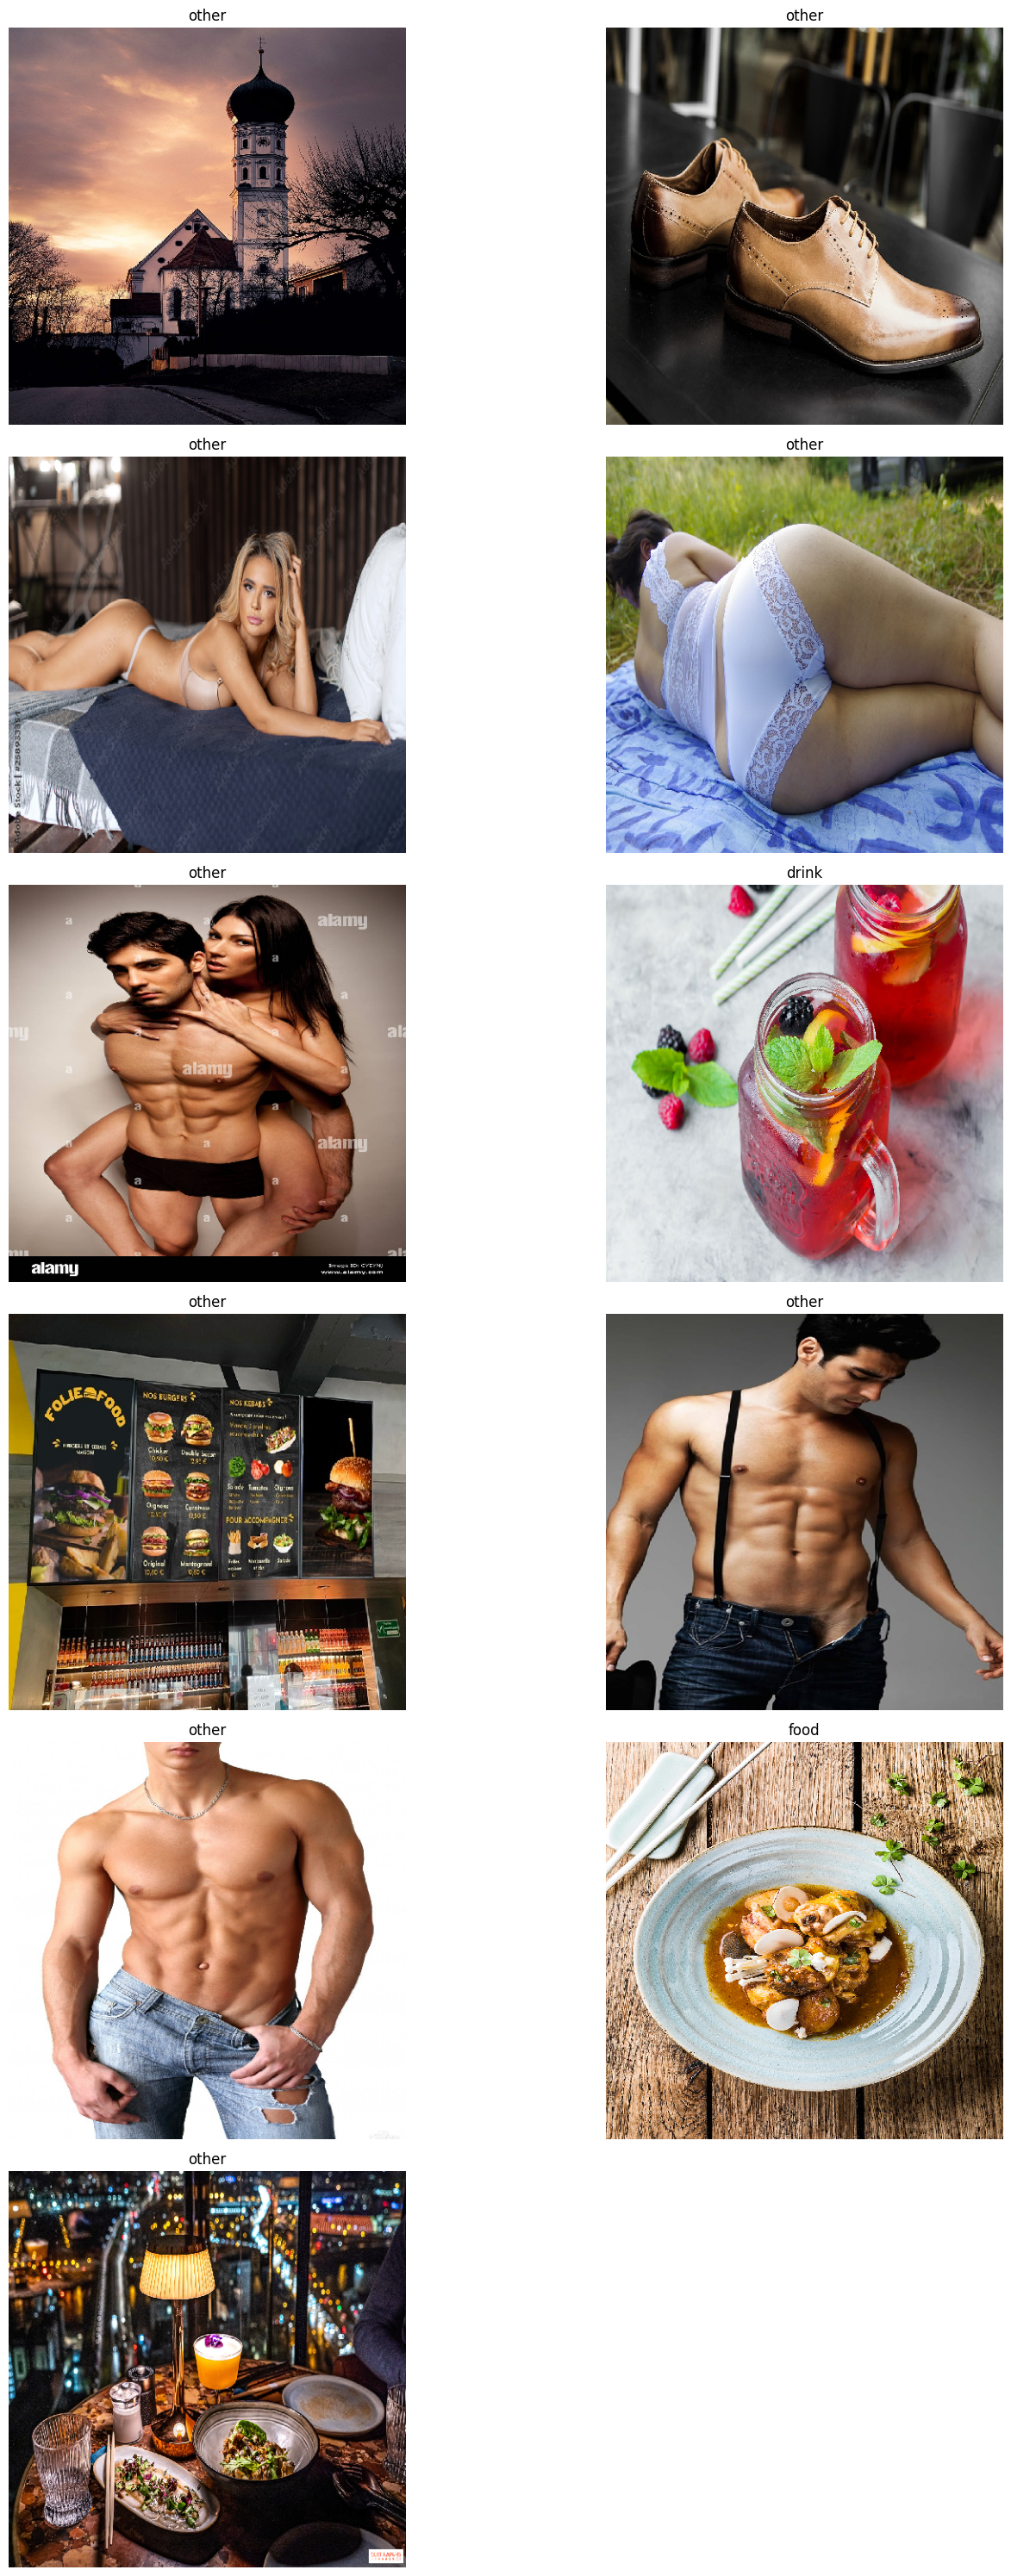

In [10]:
# Chemin du dossier contenant les images de test
folder_path = 'data/test'

# Listes pour stocker les images et les étiquettes prédites
images = []
labels = []

# Taille cible des images
target_size = (480, 480)

# Catégories possibles
categories = ['drink', 'food', 'other']

# Parcours de tous les fichiers dans le dossier
for file in os.listdir(folder_path):
    if file.endswith('.jpg'): 
        img_path = os.path.join(folder_path, file)
        # Chargement et redimensionnement de l'image
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Prédiction de la classe de l'image à l'aide du modèle chargé
        prediction = loaded_model.predict(img_array, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)
        predicted_class_label = categories[predicted_class[0]]
        labels.append(predicted_class_label)

        images.append(img)

# Calcul du nombre d'images et de lignes pour le tracé
num_images = len(images)
num_rows = math.ceil(num_images / 2)

# Tracé des images avec les étiquettes prédites
plt.figure(figsize=(15, num_rows * 5))
for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(num_rows, 2, i + 1)
    plt.imshow(image.img_to_array(img).astype('uint8'))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()